In [1]:
import sys
import glob
from sklearn.utils import resample
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
import random
import numpy as np
import matplotlib
matplotlib.use('agg')
from utility.math_utility import get_kl_rows
from matplotlib.pyplot import *
from Bio import SeqIO
from utility.file_utility import FileUtility
import matplotlib.pyplot as plt

# TB public data 

In [2]:
list_of_files = glob.glob("/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/*.fastq")

In [3]:
len(list_of_files)

10

In [4]:
list_of_files

['/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample10.fastq',
 '/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample9.fastq',
 '/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample8.fastq',
 '/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample2.fastq',
 '/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample6.fastq',
 '/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample4.fastq',
 '/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample3.fastq',
 '/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample1.fastq',
 '/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample5.fastq',
 '/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample7.fastq']

In [5]:
#list_of_files2 = [x.replace("/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/", '') for x in list_of_files]

In [6]:
fasta_files, mapping = FileUtility.read_fasta_directory('/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/',
                                                        'fastq')

In [7]:
fasta_files 

['/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample1.fastq',
 '/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample10.fastq',
 '/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample2.fastq',
 '/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample3.fastq',
 '/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample4.fastq',
 '/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample5.fastq',
 '/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample6.fastq',
 '/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample7.fastq',
 '/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample8.fastq',
 '/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample9.fastq']

In [8]:
mapping

{'/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample1.fastq': 0,
 '/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample10.fastq': 1,
 '/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample2.fastq': 2,
 '/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample3.fastq': 3,
 '/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample4.fastq': 4,
 '/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample5.fastq': 5,
 '/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample6.fastq': 6,
 '/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample7.fastq': 7,
 '/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample8.fastq': 8,
 '/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/small_fastq_files1mil_lines/sample9.fastq': 9}

# Bootstrapping to find a proper sampling size

In [9]:
input_dir = fasta_files
output_dir = '/Users/jamesmashiyane/Desktop/TB_Fastq_Test_Data/fastq_1mil__output_dir/'
seqtype='fastq'
sampling_sizes=[10, 20,50]
n_resamples=10
M=10

In [10]:
# dictionary for different k-values
# are the sampling sizes
N_axis = dict()
# are mean of distances among k-mer distribution resamples
D_S = dict()
# are std of distances among k-mer distribution resamples
std_D_S = dict()
# are mean of distances between k-mer distribution resamples and the whole sample k-mer distribution
D_R = dict()
# are std of distances between k-mer distribution resamples and the whole sample k-mer distribution
std_D_R = dict()

In [11]:
def _get_kmer_distribution(sample_file, k, sample_size, number_of_samples):
        '''
        generate k-mer distribution
        :param sample_file:
        :param k:
        :param sample_size:
        :param number_of_samples:
        :return:
        '''
        vocab = [''.join(xs) for xs in itertools.product('atcg', repeat=k)]
        vectorizer = TfidfVectorizer(use_idf=False, vocabulary=vocab, analyzer='char', ngram_range=(k, k),
                                     norm=None, stop_words=[], lowercase=True, binary=False)
        corpus = []
        # read the sequences from the fasta file
        for cur_record in SeqIO.parse(sample_file, 'fasta' if seqtype == 'fsa' else seqtype):
            corpus.append(str(cur_record.seq).lower())
        if sample_size == -1:
            sample_size = len(corpus)
            resamples = [corpus]
        else:
            resamples = []
            for i in range(number_of_samples):
                resamples.append(resample(corpus, replace=True, n_samples=sample_size))
        vect = []
        for rs in resamples:
            vect.append(
                normalize(np.sum(vectorizer.fit_transform(rs).toarray(), axis=0).reshape(1, -1), axis=1, norm='l1')[0])
        return vect

In [12]:
def get_stats_samples(k_mer):
        '''
        get the D_R and D_S
        :param k_mer:
        :return:
        '''
        x = []
        y = []
        y_tot = []
        error = []
        error_tot = []
        # To find the files
        sample_files = input_dir
        sample_files = random.sample(sample_files, M)

        # To iterate over the sampling sizes
        for sample_size in sampling_sizes:
            distance_i = []
            tot_dist_i = []
            print(' sampling size ', sample_size, ' is started ...')
            # To iterate over random files
            for sample_file in sample_files:
                comp_dist = _get_kmer_distribution(sample_file, k_mer, -1, 1)
                resamples_kmers = _get_kmer_distribution(sample_file, k_mer, sample_size, n_resamples)
                distance_i.append(np.mean(get_kl_rows(np.array(resamples_kmers))))
                tot_dist_i = tot_dist_i + list(
                    get_kl_rows(np.vstack((np.array(resamples_kmers), comp_dist[0])))[0:10, 10])
            print(' sampling size ', sample_size, ' is completed.')
            mean_distance = np.mean(distance_i)
            std_distance = np.std(distance_i)
            mean_total_distance = np.mean(tot_dist_i)
            std_total_distance = np.std(tot_dist_i)
            x.append(sample_size)
            y.append(mean_distance)
            error.append(std_distance)
            y_tot.append(mean_total_distance)
            error_tot.append(std_total_distance)
        return x, y, error, y_tot, error_tot

In [13]:
def add_kmer_sampling(k_mer):
        '''
        :param k_mer: k_mer bootstrapping to add in the analysis
        :return:
        '''
        N_axis[k_mer], D_S[k_mer], std_D_S[k_mer], D_R[k_mer], std_D_R[k_mer] = get_stats_samples(k_mer)

In [14]:
## add k-mer samplings
# To see what the code does, let's use two values of k
for k in [3,4]:
    print(k,'-mer bootstrapping..')
    add_kmer_sampling(k)

3 -mer bootstrapping..
 sampling size  10  is started ...
 sampling size  10  is completed.
 sampling size  20  is started ...
 sampling size  20  is completed.
 sampling size  50  is started ...
 sampling size  50  is completed.
4 -mer bootstrapping..
 sampling size  10  is started ...
 sampling size  10  is completed.
 sampling size  20  is started ...
 sampling size  20  is completed.
 sampling size  50  is started ...
 sampling size  50  is completed.


In [15]:
import matplotlib.pyplot as plt
%pylab inline
%matplotlib inline 

Populating the interactive namespace from numpy and matplotlib


/Users/jamesmashiyane/anaconda3/envs/james35/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['draw_if_interactive', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


[3, 4]


Text(0.5, 1.01, '(ii) Unrepresentativeness $\\bar{D_R}$, with respect to sample size (N)')

/Users/jamesmashiyane/anaconda3/envs/james35/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/jamesmashiyane/anaconda3/envs/james35/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


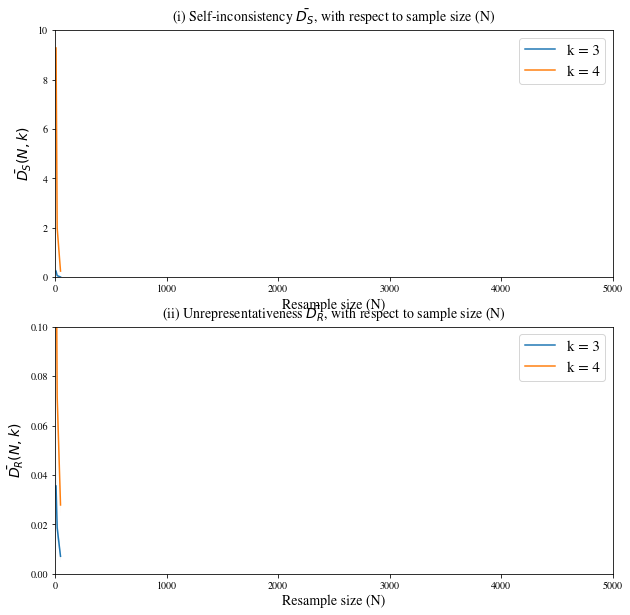

In [16]:
file_name = fasta_files
dataset_name = 'body-site'

fig = plt.figure(figsize=(10, 10))
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
#matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')
plt.rc('text', usetex=False)
ax = fig.add_subplot(2,1,1)
k_mers = list(N_axis.keys())
print(k_mers)
legend_vals = []
for k in k_mers:
    ax.plot(N_axis[k], np.array(D_S[k]))
    ax.fill_between(N_axis[k], np.array(D_S[k]) - np.array(std_D_S[k]),
                    np.array(D_S[k]) + np.array(std_D_S[k]), alpha=0.2, 
                    linewidth=4,linestyle='dashdot', antialiased=True)
    legend_vals.append('k = ' + str(k))
ax.legend(legend_vals, loc='upper right', prop={'size': 15}, ncol=1)
plt.xlabel('Resample size (N)', fontsize=14)
plt.ylabel(r'$\bar{D_S}(N,k)$', fontsize=14)
plt.xlim([0, 5000])
plt.ylim([0, 10])
ax.set_title(r'(i) Self-inconsistency $\bar{D_S}$, with respect to sample size (N)',
            fontsize=14, y=1.01)
#-------------------------------
ax = fig.add_subplot(2,1,2)
k_mers = list(N_axis.keys())
legend_vals = []
for k in k_mers:
    ax.plot(N_axis[k], np.array(D_R[k]))
    ax.fill_between(N_axis[k], np.array(D_R[k]) - np.array(std_D_R[k]),
                    np.array(D_R[k]) + np.array(std_D_R[k]), alpha=0.2, linewidth=4,
                    linestyle='dashdot', antialiased=True)
    legend_vals.append('k = ' + str(k))
ax.legend(legend_vals, loc='upper right', prop={'size': 15}, ncol=1)
xlim([0, 5000])
ylim([0, 0.1])
xlabel('Resample size (N)', fontsize=14)
ylabel(r'$\bar{D_R}(N,k)$', fontsize=14)
ax.set_title(r'(ii) Unrepresentativeness $\bar{D_R}$, with respect to sample size (N)',
            fontsize=14, y=1.01)

In [17]:
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
import numpy as np
from multiprocessing import Pool
import tqdm
import random
from scipy import sparse
from utility.file_utility import FileUtility
from Bio import SeqIO
import timeit

# Build Representations

In [18]:
def get_kmer_resamples(sample_file, k, sample_size, number_of_samples):
        '''
        generate k-mer distribution
        :param sample_file:
        :param k:
        :param sample_size:
        :param number_of_samples:
        :return:
        '''
        sample_file = get_file(sample_file)
        
        corpus = []
        # read the sequences from the fasta file
        for cur_record in SeqIO.parse(StringIO(sample_file.decode('utf-8')), 'fasta' if seqtype == 'fsa' else seqtype):
            corpus.append(str(cur_record.seq).lower())
        if sample_size == -1:
            sample_size = len(corpus)
            resamples = [corpus]
        else:
            resamples = []
            for i in range(number_of_samples):
                resamples.append(resample(corpus, replace=True, n_samples=sample_size))
        return resamples

In [19]:
class MetagenomicRepresentationTest:
    '''
        Make k-mer from directory of fasta files
    '''

    def __init__(self, fasta_files, indexing, sampling_number=3000, num_p=20):
        '''
        :param fasta_files: list of fasta files
        :param indexing: the index
        :param sampling_number:
        :param num_p:
        '''
        self.fasta_files=fasta_files
        self.num_p=num_p
        self.sampling_number=sampling_number
        self.indexing=indexing


    def get_corpus(self, file_name_sample):
        '''
        :param file_name_sample:
        :return:
        '''
        file_name=file_name_sample[0]
        sample_size=file_name_sample[1]
        corpus=[]
        for cur_record in SeqIO.parse(file_name,'fasta'):
            corpus.append(str(cur_record.seq).lower())
        return file_name, random.sample(corpus, min(sample_size,len(corpus))) 
    

    def generate_kmers_all(self, k, save=False):
        '''
        :param k:
        :param save:
        :return:
        '''
        self.k=k
        self.vocab = [''.join(xs) for xs in itertools.product('atcg', repeat=k)]
        self.vocab.sort()
        self.vectorizer = TfidfVectorizer(use_idf=False, vocabulary=self.vocab, analyzer='char', ngram_range=(k, k),
                                          norm=None, stop_words=[], lowercase=True, binary=False)

        data = np.zeros((len(self.fasta_files), len(self.vocab))).astype(np.float64)

        # multi processing extraction of k-mer distributions
        t_steps=[]
        s_steps=[]
        pool = Pool(processes=self.num_p)
        for ky, (v,t,s) in tqdm.tqdm(pool.imap_unordered(self.get_kmer_distribution, self.fasta_files, chunksize=1),
                               total=len(self.fasta_files)):
            data[self.indexing[ky], :] = v
            t_steps.append(t)
            s_steps.append(s)

        # normalize the frequencies
        data = normalize(data, axis=1, norm='l1')
        # The only time I see data being converted to csr_matrix
        #data = sparse.csr_matrix(data)
        if save:
            FileUtility.save_obj(save, data)
            FileUtility.save_list(save+'_meta',self.fasta_files)
            # ': '.join(['mean_time', str(np.mean(t_steps))]), ': '.join(['std_time', str(np.std(t_steps))])
            FileUtility.save_list(save+'_log',[': '.join(['mean_size', str(np.mean(s_steps))]), ': '.join(['std_size', str(np.std(s_steps))])])
        return data

    def get_kmer_distribution(self, file_name):
        '''

        :param file_name:
        :return:
        '''
        start = timeit.timeit()
        corpus=[]
        for cur_record in SeqIO.parse(file_name,'fasta'):
            corpus.append(str(cur_record.seq).lower())
        tot_size=len(corpus)
        if self.sampling_number==-1:
            random.shuffle(corpus)
        else:
            corpus = random.sample(corpus, min(self.sampling_number,len(corpus)))
        end = timeit.timeit()
        return file_name, (np.sum(self.vectorizer.fit_transform(corpus).toarray(), axis=0),end - start,tot_size)

In [20]:
class FastaRepresentations(object):
    '''
        Make k-mer from single fasta file
        where the headers contain info about the label
    '''
    def __init__(self, fasta_address, label_modifying_func=str):
        '''
        :param fasta_address:
        :param label_modifying_func: extract label from the header
        '''
        self.labels=[]
        self.corpus=[]
        for cur_record in SeqIO.parse(fasta_address, 'fasta'):
            self.corpus.append(str(cur_record.seq).lower())
            self.labels.append(str(cur_record.id).lower())
        self.labels=[label_modifying_func(l) for l in self.labels]

    def get_samples(self, envs, N):
        '''
        :param envs: list of labels
        :param N: sample size
        :return: extract stratified with size N corpus and label list
        '''
        labels=[]
        corpus=[]
        for env in envs:
            selected=[idx for idx,v in enumerate(self.labels) if env==v]
            if N==-1:
                N=len(selected)
            idxs=random.sample(selected, N)
            corpus=corpus+[self.corpus[idx] for idx in idxs]
            labels=labels+[self.labels[idx] for idx in idxs]
        return corpus, labels

    def get_vector_rep(self, corpus, k, restricted=True):
        '''
        :param corpus:
        :param k: k-mer size
        :param restricted: restricted to known values
        :return:
        '''
        if restricted:
            vocab = [''.join(xs) for xs in itertools.product('atcg', repeat=k)]
            tf_vec = TfidfVectorizer(use_idf=True, vocabulary=vocab, analyzer='char', ngram_range=(k, k),
                                                  norm='l1', stop_words=[], lowercase=True, binary=False)
        else:
            tf_vec = TfidfVectorizer(use_idf=True, analyzer='char', ngram_range=(k, k),
                                                  norm='l1', stop_words=[], lowercase=True, binary=False)
        return tf_vec.fit_transform(corpus)

In [21]:
# In this case we have already chosen which one is the best ("k,N") from analysing the graph, then we represent it 
sampling_dict={3:[20],4:[50],5:[100]}
# number of cores
nump_p=20
for k in sampling_dict.keys():
    for N in sampling_dict[k]:
        print(k,'-mers with sampling size ',N)
        RS=MetagenomicRepresentationTest(fasta_files, mapping, N, nump_p)
        # path to save the generated files
        RS.generate_kmers_all(k,save='/Users/jamesmashiyane/Desktop/MicroPheno-master/data/gz_body_site_data/10_seq_files/16s_samples10_'+str(k)+'-mers_rate_complete_seq_'+str(N))

3 -mers with sampling size  20


  0%|          | 0/10 [00:00<?, ?it/s]

ValueError: Found array with 0 sample(s) (shape=(0, 64)) while a minimum of 1 is required.

In [ ]:
# load data for ML

In [ ]:
# we have three datasets that we can check the state of the art from, k,N = (3,20), (4,50), and (5,100) 

from numpy import load

data = load('/Users/jamesmashiyane/Desktop/MicroPheno-master/data/gz_body_site_data/10_seq_files/16s_samples10_5-mers_rate_complete_seq_100.npz')
lst = data.files
#for item in lst:
#    print(item)
#    print(data[item])

In [ ]:
lst

In [ ]:
def load_sparse_csr(filename):
        loader = np.load(filename)
        return sparse.csr_matrix((loader['data'], loader['indices'], loader['indptr']), shape=loader['shape']).toarray()

In [ ]:
X_3_mer=load_sparse_csr('/Users/jamesmashiyane/Desktop/MicroPheno-master/data/gz_body_site_data/10_seq_files/16s_samples10_3-mers_rate_complete_seq_20.npz')
X_4_mer=load_sparse_csr('/Users/jamesmashiyane/Desktop/MicroPheno-master/data/gz_body_site_data/10_seq_files/16s_samples10_4-mers_rate_complete_seq_50.npz')
X_5_mer=load_sparse_csr('/Users/jamesmashiyane/Desktop/MicroPheno-master/data/gz_body_site_data/10_seq_files/16s_samples10_5-mers_rate_complete_seq_100.npz')

In [ ]:
X_5_mer.shape

In [ ]:
import pickle
pickle_in = open("/Users/jamesmashiyane/Desktop/MicroPheno-master/data/gz_body_site_data/10_seq_files/16s_samples10_5-mers_rate_complete_seq_100.pickle","rb")
example_dict = pickle.load(pickle_in)

In [ ]:
example_dict.shape

In [ ]:
y = X_5_mer - example_dict